## Running the model

To run ASPECT using the .prm file that decribes a 2D box heated at the bottom (more details in the [previous notebook](./2_understanding_the_prm_file.ipynb)), execute the following line :

In [ ]:
%%capture
! /home/arushi/opt/aspect/aspect-build/aspect-release mantle-flow.prm ;

> In this above cell, it is assumed that the ASPECT directory is installed system-wide or that you are using the HUBzero ASPECT installation. If not, modify the aspect executable to the location where it is installed.

#### Running ASPECT in parallel
ASPECT can run in parallel on a single machine, using MPI libraries. Run the code below to try this out:

In [ ]:
%%capture
!mpirun -np 2 /home/arushi/opt/aspect/aspect-build/aspect-release mantle-flow.prm

Here, the "-np" tag specifies the number of processes. As a general guideline, using more processors is faster if every processesor has at least 30,000 degrees of freedom. In ASPECT, you will find the number of degrees of freedom at the top of `log.txt` stored in the output directory.

## Visualizing Results

Now, we're ready to start visualizing the ASPECT output files. We will begin with file statistics. The following function `read_statistics()` reads the statistics file generated above and returns a pandas dataframe which is then used for plotting. The function is taken from [here](https://github.com/geodynamics/aspect/blob/main/contrib/python/notebooks/read_output_files/example.ipynb) with minor edits.

The ASPECT [manual](https://aspect-documentation.readthedocs.io/en/latest/user/run-aspect/visualizing-results/index.html) also goes over another tool, Paraview, used to visualized the simulation results. Here, we will use the matplotlib library to be able to plot the results inside a notebook.

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import tables
import scipy.interpolate as interpolate
import meshio
from matplotlib import animation
from IPython.display import HTML

In [ ]:
def read_statistics(fname):
    """ Read the statistics file output by CIG-ASPECT

    return a pandas table, where names are taken from the statistics file.
    """
    # Remove comments in the header:
    header = []
    header_read = True

    with open(fname) as f:
        while header_read :
            line = f.readline()
            if line[0] == '#':
                idx_start = line.find(":")
                header.append(line[idx_start+2:-1])
            else:
                header_read = False

    # Read the data here
    values = pd.read_csv(fname, skiprows=len(header), header=None, delim_whitespace=True, names=header)
    return values

In [ ]:
# Here, we need to provide the location of the statistics file.
# The default location is "output-mantle-flow" directory as
# provided in the .prm file

output_dir =  "./output-mantle-flow/"

# Provide the name of the statistics file here
statistics = output_dir + "statistics"
data =  read_statistics(statistics)

<ipython-input-15-76b8737eefec>:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  values = pd.read_csv(fname, skiprows=len(header), header=None, delim_whitespace=True, names=header)


In [ ]:
# Just to look at the returned data from the function above
data.head()

,Time step number,Time (years),Time step size (years),Number of mesh cells,Number of Stokes degrees of freedom,Number of temperature degrees of freedom,Iterations for temperature solver,Iterations for Stokes solver,Velocity iterations in Stokes preconditioner,Schur complement iterations in Stokes preconditioner,...,Max. velocity (m/year),Minimal temperature (K),Average temperature (K),Maximal temperature (K),Average nondimensional temperature (K),"Outward heat flux through boundary with indicator 0 (""left"") (W)","Outward heat flux through boundary with indicator 1 (""right"") (W)","Outward heat flux through boundary with indicator 2 (""bottom"") (W)","Outward heat flux through boundary with indicator 3 (""top"") (W)",Visualization file name
0,0,0.000000e+00,0.000000e+00,64,659,289,0,7,9,9,...,0.000038,273.0,1936.50000,3600.0,0.500000,0.0,0.0,-21891.7794,21891.8182,output-mantle-flow/solution/solution-00000
1,1,4.930772e+09,4.930772e+09,64,659,289,23,7,9,9,...,0.000159,273.0,1936.52376,3600.0,0.500007,0.0,0.0,-22113.9606,22119.8967,output-mantle-flow/solution/solution-00001
2,2,6.111245e+09,1.180473e+09,64,659,289,14,7,9,9,...,0.000309,273.0,1936.53885,3600.0,0.500012,0.0,0.0,-22765.0947,22780.9508,output-mantle-flow/solution/solution-00002
3,3,6.716755e+09,6.055095e+08,64,659,289,11,7,9,9,...,0.000467,273.0,1936.55049,3600.0,0.500015,0.0,0.0,-23842.7697,23871.1504,output-mantle-flow/solution/solution-00003
4,4,7.117337e+09,4.005826e+08,64,659,289,9,7,9,9,...,0.000624,273.0,1936.56062,3600.0,0.500018,0.0,0.0,-25344.5943,25388.3762,output-mantle-flow/solution/solution-00004


Text(0, 0.5, 'Velocity (m/year)')

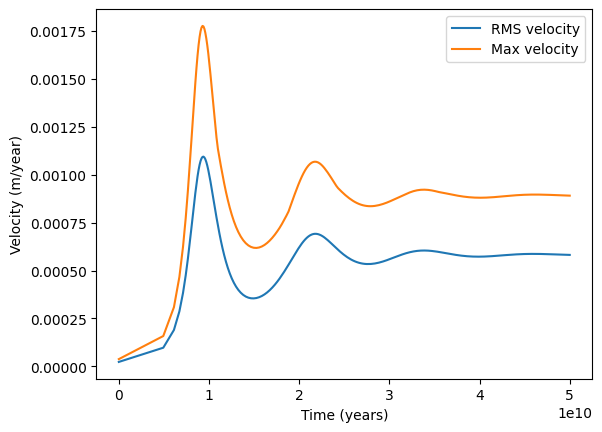

In [ ]:
# Since we are interested in the convective vigor, let's plot the
# RMS velocity and max velocity over time in our model
fig, ax = plt.subplots()

ax.plot(data["Time (years)"], data["RMS velocity (m/year)"], label="RMS velocity")
ax.plot(data["Time (years)"], data["Max. velocity (m/year)"], label="Max velocity")
ax.legend()
ax.set_xlabel("Time (years)")
ax.set_ylabel("Velocity (m/year)")

In the above plot, notice how the velocity plateaus after ~ 3x10^7 years. This suggests that steady state is achieved in our model from heat transported through convection.

This is also be seen looking at the temperature distribution over time in the model. The following function plots the modeled temperature solution using the output `*.h5` files.

In [ ]:
# Load the visualization output files
viz_files = sorted(glob.glob(output_dir + 'solution/solution*.h5'))

# Define the mesh based on the model domain. You can find the dimensions
# under subsection Geometry Model in the .prm file
npts  = 100
mesh_x, mesh_y = np.meshgrid(np.linspace(0, 4200e3, npts), \
                             np.linspace(0, 3000e3, npts))

In [ ]:
def read_solution_files (fname, attribute):
    '''
    This function takes in the aspect solution file and the mesh file,
    and returns the desired field vector interpolated on the mesh coordinates.
    Both solution and mesh files are assumed to be in the hdf5 file format.

    Inputs:
    fname (str)     : The name of the output solution file
    attribute (str) : ASPECT saves several computed fields of the model (density,
                      temperature, viscosity), this variable specifies the name
                      of the computed field we want to plot.

    Output:
    viz_data (list) : The output field interpolated on the mesh points.
    '''

    mesh     = tables.open_file(output_dir + '/solution/mesh-00000.h5', mode='r')
    fields   = tables.open_file(fname, mode='r')
    nodes    = mesh.root.nodes
    field    = getattr(fields.root, attribute)
    coords   = np.array([x for x in nodes])
    values   = np.array([t for t in field])[:,0]
    fn       = interpolate.LinearNDInterpolator(coords,values)
    viz_data = (fn(mesh_x, mesh_y))

    return viz_data

In [ ]:
# Create figure, axis, and colorbar for the animation
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
data_to_plot = read_solution_files(viz_files[0], 'T')
mesh     = ax1.pcolormesh(mesh_x, mesh_y, data_to_plot, cmap='RdBu_r')
colorbar = fig.colorbar(mesh, ax=ax1)
#---------------------------------------------------------------------------

def animate(time_step):
    '''
    This function takes the time step, i, and plots the output solution field
    on the mesh.

    Inputs:
    time_step (int)       : The time step number in the solution
    skip_time_steps (int) : Number of time steps between each graphical output
    '''

    ax1.clear()
    data_to_plot = read_solution_files(viz_files[time_step], 'T')
    mesh = ax1.pcolormesh(mesh_x, mesh_y, data_to_plot, cmap='RdBu_r')
    colorbar.update_normal(mesh)

    # Add a contour to approximate the shape of the convection cell
    ax1.contour(mesh_x, mesh_y, data_to_plot, levels=[1673], colors='k')

    ax1.set_title(f'Temperature field at time step {time_step}')
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')

    return [mesh]

In [ ]:
# Now, let's plot the evolution of the temperatures in the box

ani = animation.FuncAnimation(fig, animate, frames=(len(viz_files)))
HTML(ani.to_jshtml())

#### Model Analysis
In the above cell, the black contour approximately delineates the convection cell. To the dominance of convection over conduction, we need to look at the Rayleigh number and Nusselt number.

 &nbsp;<div style="text-align: right">  
    &rarr; <b>NEXT: [Rayleigh Nusselt Relationship](./4_Rayleigh_Nusselt_Relationship.ipynb) </b> <a href=""></a> &nbsp;&nbsp;
     <img src="../assets/education-gem-notebooks_icon.png" alt="icon"  style="width:4%">
  </div>